In [1]:
#!/usr/bin/env python3
import numpy as np
import os
import netCDF4
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LinearRing
from pyproj import Proj
import time
from copy import deepcopy
import geopandas as gp
import fiona
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io as cio
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter, Gridliner


In [2]:
def plot_coords(ax, poly, col, zorder=0, linewidth=1):
    pts = list(poly.exterior.coords)
    x, y = zip(*pts)
    ax.plot(x, y, c=col, zorder=zorder, linewidth=linewidth)

def plot_centres(ax, centre, col):
    pts = list(centre.coords)
    x, y = zip(*pts)
    ax.plot(x, y, col+'o')

In [19]:
#############################
# USER INPUT
#############################

path='/home/jstreffi/thesis/data/'
location='north_sea_small' # 'east med'
plot_connections=True
skip_mask = True 

if location =='north_sea_small':
    min_lon=5.25
    max_lon=7.6
    min_lat=54.1
    max_lat=55.3
    cities = {}

elif location =='azors':
    min_lon=-30
    max_lon=-24.5
    min_lat=36.7
    max_lat=40.3  
    cities = {}
elif location =='atlantic':
    min_lon=-30
    max_lon=-24.5
    min_lat=26.7
    max_lat=30.3  
    cities = {}
    
grid_source = 'feom'
grid_target = 'A096'
GridFile = path+'/grids.nc'
MasksFile = path+'/masks.nc'

In [4]:
cells_coord_source=[]
centres_coord_source=[]

start_time = time.time()
print("Reading source files...")
fin = netCDF4.Dataset(GridFile, 'r')
kin = netCDF4.Dataset(MasksFile, 'r')

grid_in_size_source = len(fin.dimensions["x_"+grid_source]) * len(fin.dimensions["y_"+grid_source])
grid_corners_source = len(fin.dimensions["crn_"+grid_source])

grid_lat_source = fin.variables[grid_source+".lat"][:].flatten()
grid_lon_source = fin.variables[grid_source+".lon"][:].flatten()
grid_corner_lat_source = fin.variables[grid_source+".cla"][:].reshape(grid_corners_source,-1)
grid_corner_lon_source = fin.variables[grid_source+".clo"][:].reshape(grid_corners_source,-1)

grid_mask = kin.variables[grid_target+".msk"][:].flatten()

for i in range(grid_in_size_source):
    cells_coord_source.append([[grid_corner_lon_source[j,i],grid_corner_lat_source[j,i]] for j in range(grid_corners_source)])
    centres_coord_source.append([grid_lon_source[i],grid_lat_source[i]])
print("Source files loaded in {:.3f} secs.".format(time.time()-start_time))


cells_coord_target=[]
centres_coord_target=[]

start_time = time.time()
print("Reading target files...")
fin = netCDF4.Dataset(GridFile, 'r')
kin = netCDF4.Dataset(MasksFile, 'r')

grid_in_size_target = len(fin.dimensions["x_"+grid_target]) * len(fin.dimensions["y_"+grid_target])
grid_corners_target = len(fin.dimensions["crn_"+grid_target])

grid_lat_target = fin.variables[grid_target+".lat"][:].flatten()
grid_lon_target = fin.variables[grid_target+".lon"][:].flatten()
grid_corner_lat_target = fin.variables[grid_target+".cla"][:].reshape(grid_corners_target,-1)
grid_corner_lon_target = fin.variables[grid_target+".clo"][:].reshape(grid_corners_target,-1)

grid_mask = kin.variables[grid_target+".msk"][:].flatten()

for i in range(grid_in_size_target):
    cells_coord_target.append([[grid_corner_lon_target[j,i],grid_corner_lat_target[j,i]] for j in range(grid_corners_target)])
    centres_coord_target.append([grid_lon_target[i],grid_lat_target[i]])
print("target files loaded in {:.3f} secs.".format(time.time()-start_time))


# Shapely approach
ori_coord = deepcopy(cells_coord_target)
ori_centre = deepcopy(centres_coord_target)


Reading source files...
Source files loaded in 9.375 secs.
Reading target files...
target files loaded in 0.954 secs.


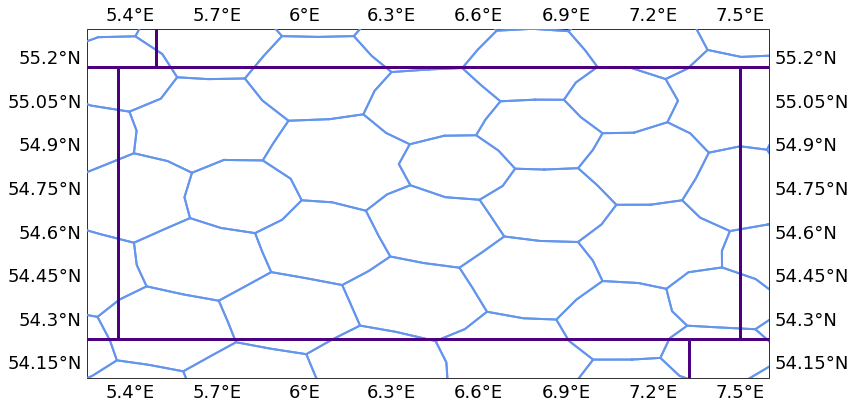

In [20]:
# Set up plot with cartopy feature
fig, ax = plt.subplots(figsize=((max_lon-min_lon)*5, (max_lat-min_lat)*5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon,min_lat, max_lat],crs=ccrs.PlateCarree())   
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.coastlines()

# Create grid lines and labels for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
gridlines.xformatter = LongitudeFormatter()
gridlines.yformatter = LatitudeFormatter()

# Set the fontsize of the labels
gridlines.xlabel_style = {'size': 18}
gridlines.ylabel_style = {'size': 18}


first_cell =  0       # Restart cell (useful for dealing with a few errors at a time)
# Find connection to nearest N neigbours for points inside the box
if plot_connections:
    for i in range(first_cell,grid_in_size_source):
        c = cells_coord_source[i]
        if grid_lat_source[i] > min_lat-3 and grid_lat_source[i] < max_lat+3:
            if grid_lon_source[i] > min_lon-3 and grid_lon_source[i] < max_lon+3:
                # Preprocess longitudes
                lons = np.array([j[0] for j in c])
                lats = np.array([j[1] for j in c])


                # Cell across periodicity
                if abs(np.max(lons)-np.min(lons)) > 100:
                    blon = np.mean(lons)
                    if abs(np.max(lons) - blon) > abs(np.min(lons) - blon):
                        if abs(centres_coord[i][0] - np.min(lons)) > abs(np.max(lons) - centres_coord_source[i][0]):
                            centres_coord_source[i][0] -= 360.
                        for j in c:
                            if j[0] > blon:
                                j[0] -= 360
                    else:
                        if abs(centres_coord[i][0] - np.min(lons)) < abs(np.max(lons) - centres_coord_source[i][0]):
                            centres_coord_source[i][0] += 360.
                        for j in c:
                            if j[0] < blon:
                                j[0] += 360
                off = 0.02
                r = LinearRing(c)
                poly = Polygon(r)
                ctr = Point(centres_coord_source[i])
                plot_coords(ax, poly, col='cornflowerblue', zorder=5, linewidth=2)
                
first_cell =  0       # Restart cell (useful for dealing with a few errors at a time)
if plot_connections:
    for i in range(first_cell,grid_in_size_target):
        c = cells_coord_target[i]
        if grid_lat_target[i] > min_lat-3 and grid_lat_target[i] < max_lat+3:
            if grid_lon_target[i] > min_lon-3 and grid_lon_target[i] < max_lon+3:
                # Preprocess longitudes
                lons = np.array([j[0] for j in c])
                lats = np.array([j[1] for j in c])


                # Cell across periodicity
                if abs(np.max(lons)-np.min(lons)) > 100:
                    blon = np.mean(lons)
                    if abs(np.max(lons) - blon) > abs(np.min(lons) - blon):
                        if abs(centres_coord[i][0] - np.min(lons)) > abs(np.max(lons) - centres_coord_target[i][0]):
                            centres_coord_target[i][0] -= 360.
                        for j in c:
                            if j[0] > blon:
                                j[0] -= 360
                    else:
                        if abs(centres_coord[i][0] - np.min(lons)) < abs(np.max(lons) - centres_coord_target[i][0]):
                            centres_coord_target[i][0] += 360.
                        for j in c:
                            if j[0] < blon:
                                j[0] += 360
                off = 0.02
                r = LinearRing(c)
                poly = Polygon(r)
                ctr = Point(centres_coord_target[i])
                plot_coords(ax, poly, col='indigo', zorder=6, linewidth=3)
            
            
# Plot some cities
if len(cities)>0:
    for city, coords in cities.items():
        ax.plot(coords[1], coords[0], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black', transform=ccrs.Geodetic(),zorder=5)
        ax.text(coords[1]+0.03, coords[0]-0.08, city, fontsize=14, transform=ccrs.Geodetic(),zorder=4)

#sc = ax.scatter(grid_lon_source, grid_lat_source, color='blue', alpha=1, s=80,marker='s', edgecolors= "black",transform=ccrs.PlateCarree(),zorder=2)
#ax.scatter(grid_lon_target, grid_lat_target, c=grid_mask, alpha=1, s=200, marker='D', edgecolors= "black", transform=ccrs.PlateCarree(),zorder=3)

plt.tight_layout()
plt.savefig('rndwalk_'+location+'.png',dpi=300)